In [1]:
import numpy as np
import pandas as pd

In [4]:
df = pd.read_csv('data/Epileptic Seizure Recognition.csv')
df.drop(['Unnamed'], axis=1, inplace=True)

df['y'] = df['y'].apply(lambda x: int(x == 1))

In [5]:
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,135,190,229,223,192,125,55,-9,-33,-38,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,0
1,386,382,356,331,320,315,307,272,244,232,...,164,150,146,152,157,156,154,143,129,1
2,-32,-39,-47,-37,-32,-36,-57,-73,-85,-94,...,57,64,48,19,-12,-30,-35,-35,-36,0
3,-105,-101,-96,-92,-89,-95,-102,-100,-87,-79,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,0
4,-9,-65,-98,-102,-78,-48,-16,0,-21,-59,...,4,2,-12,-32,-41,-65,-83,-89,-73,0


In [6]:
from random import triangular
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop(['y'], axis=1), df['y'],
                                                     test_size=0.2, random_state=123, 
                                                     stratify=df['y'])

#### Бейзлайн с использование маленький RandomForest

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score


def print_result(X_train, X_test, y_train, y_test, clf):
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)

    acc_train = accuracy_score(y_train, y_train_pred)
    acc_test = accuracy_score(y_test, y_test_pred)
    print(f"Accuracy for train = {round(acc_train, 3)}, accuracy for test = {round(acc_test, 3)}")
    print(classification_report(y_test, y_test_pred))


clf = RandomForestClassifier(n_estimators=20, max_depth=6).fit(X_train, y_train)
print_result(X_train, X_test, y_train, y_test, clf)

Accuracy for train = 0.959, accuracy for test = 0.949
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1840
           1       0.97      0.77      0.86       460

    accuracy                           0.95      2300
   macro avg       0.96      0.88      0.91      2300
weighted avg       0.95      0.95      0.95      2300



In [8]:
# Создадим массив с последовательностю сигналов.

sequence_lists = []
for i, tuple in enumerate(df.drop(['y'], axis=1).itertuples()):
    sequence_tmp = np.array([x for x in tuple[1:]])
    sequence_lists.append(sequence_tmp)

sequence_lists = np.array(sequence_lists)

In [15]:
X_train_seq = sequence_lists[X_train.index]
X_test_seq = sequence_lists[X_test.index]

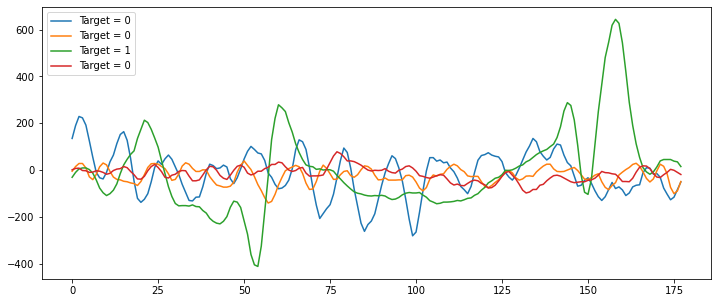

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(sequence_lists[0], label=f'Target = {df["y"].values[0]}')
plt.plot(sequence_lists[10], label=f'Target = {df["y"].values[10]}')
plt.plot(sequence_lists[30], label=f'Target = {df["y"].values[30]}')
plt.plot(sequence_lists[50], label=f'Target = {df["y"].values[50]}')
plt.legend()
plt.show()

### Попробуем разложение Фурье.

Для примера отрисуем, что получается при разложении.

In [27]:
from scipy.signal import welch
from scipy.fftpack import fft
from scipy import signal


def get_fft_values(y_values, T, N):
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
    fft_values_ = fft(y_values)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
    return f_values, fft_values

In [53]:
N = 178  # Кол-во сигналов.
t_n = 1.  # Время в с, за которое были эти сигналиы собраны.
T = t_n / N
f_values, fft_values = get_fft_values(sequence_lists[0], T, N)

In [67]:
max_freq = np.argsort(fft_values)[::-1][:30]

res_ampl = fft_values[max_freq]
res_freq = f_values[max_freq]

In [68]:
x_value = np.linspace(1,178,178)

y_res = [
    res_ampl[ii]*np.sin(
        2*np.pi*res_freq[ii]*x_value
    ) for ii in range(0,len(res_ampl))
]
composite_y_value = np.sum(y_res, axis=0)

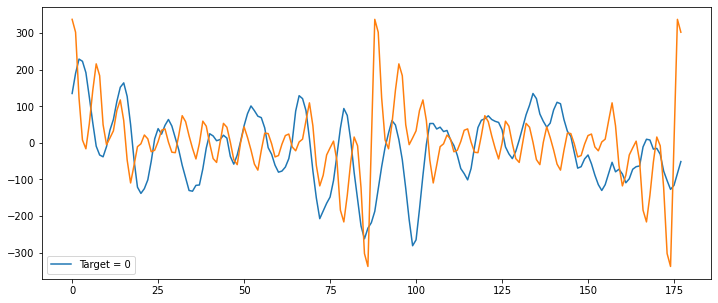

In [69]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(sequence_lists[0])
plt.plot(composite_y_value)
plt.legend()
plt.show()

Извлечем признаки, будем брать топ 10 аплитуд и их частот для каждого сигнала.
<br> После этого просто обучим RandomForestClassifier на них.

In [107]:
def get_features_fft(sequence_lists, top_n=10):
    features = []

    for sequence in sequence_lists:
        f_values, fft_values = get_fft_values(sequence, T, N)

        max_freq = np.argsort(fft_values)[::-1][:top_n]
        res_ampl = list(fft_values[max_freq])
        res_freq = list(f_values[max_freq])

        features.append(res_ampl + res_freq)

    return np.array(features)

In [108]:
X_train_fft = get_features_fft(X_train_seq)
X_test_fft = get_features_fft(X_test_seq)

In [110]:
clf = RandomForestClassifier(n_estimators=20, max_depth=6).fit(X_train_fft, y_train)
print_result(X_train_fft, X_test_fft, y_train, y_test, clf)

Accuracy for train = 0.981, accuracy for test = 0.969
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1840
           1       0.93      0.92      0.92       460

    accuracy                           0.97      2300
   macro avg       0.95      0.95      0.95      2300
weighted avg       0.97      0.97      0.97      2300



Подняли accuracy на 0.02, достаточно высокая точность классификации.

### Попробуем построить признаки на основе вейвлет преобразования.

In [121]:
import pywt
from collections import Counter
import scipy
from tqdm import tqdm


waveletname = 'rbio3.1'
res = pywt.wavedec(sequence_lists[0], waveletname)

In [124]:
def calculate_entropy(list_values):
    counter_values = Counter(list_values).most_common()
    probabilities = [elem[1]/len(list_values) for elem in counter_values]
    entropy=scipy.stats.entropy(probabilities)
    return entropy

def calculate_statistics(list_values):
    n5 = np.nanpercentile(list_values, 5)
    n25 = np.nanpercentile(list_values, 25)
    n75 = np.nanpercentile(list_values, 75)
    n95 = np.nanpercentile(list_values, 95)
    median = np.nanpercentile(list_values, 50)
    mean = np.nanmean(list_values)
    std = np.nanstd(list_values)
    var = np.nanvar(list_values)
    rms = np.nanmean(np.sqrt(list_values**2))
    return [n5, n25, n75, n95, median, mean, std, var, rms]

def calculate_crossings(list_values):
    zero_crossing_indices = np.nonzero(np.diff(np.array(list_values) > 0))[0]
    no_zero_crossings = len(zero_crossing_indices)
    mean_crossing_indices = np.nonzero(
        np.diff(np.array(list_values) > np.nanmean(list_values)))[0]
    no_mean_crossings = len(mean_crossing_indices)
    return [no_zero_crossings, no_mean_crossings]

def get_feats(list_values):
    entropy = calculate_entropy(list_values)
    crossings = calculate_crossings(list_values)
    statistics = calculate_statistics(list_values)
    return [entropy] + crossings + statistics


def get_features(sequence_lists, labels, waveletname):
    features = []
    for signal in tqdm(sequence_lists, leave=False):
        feats = []

        list_coeff = pywt.wavedec(signal, waveletname)
        for coeff in list_coeff:
            feats += get_feats(coeff)
        features.append(feats)

    X = np.array(features)
    Y = np.array(labels)
    return X, Y

In [125]:
X_train_wt, y_train = get_features(X_train_seq, y_train, waveletname)

In [126]:
X_test_wt, y_test = get_features(X_test_seq, y_test, waveletname)

In [127]:
clf = RandomForestClassifier(n_estimators=20, max_depth=6).fit(X_train_wt, y_train)
print_result(X_train_wt, X_test_wt, y_train, y_test, clf)

Accuracy for train = 0.991, accuracy for test = 0.98
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1840
           1       0.96      0.94      0.95       460

    accuracy                           0.98      2300
   macro avg       0.97      0.97      0.97      2300
weighted avg       0.98      0.98      0.98      2300



точность 0.98 на валидационной выборке

In [129]:
!pip install tsfel

In [132]:
import tsfel

# fs = 

cfg_file = tsfel.get_features_by_domain('temporal')
X_train_ts = tsfel.time_series_features_extractor(cfg_file, X_train_seq)
X_test_ts = tsfel.time_series_features_extractor(cfg_file, X_test_seq)

*** Feature extraction started ***


c:\Users\ivan.ustinov\Anaconda3\envs\study\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Using default sampling frequency set in configuration file.
  



*** Feature extraction finished ***
*** Feature extraction started ***


c:\Users\ivan.ustinov\Anaconda3\envs\study\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Using default sampling frequency set in configuration file.
  import sys



*** Feature extraction finished ***


In [134]:
X_train_ts.head(3)

,0_Absolute energy,0_Area under the curve,0_Autocorrelation,0_Centroid,0_Entropy,0_Mean absolute diff,0_Mean diff,0_Median absolute diff,0_Median diff,0_Negative turning points,0_Neighbourhood peaks,0_Peak to peak distance,0_Positive turning points,0_Signal distance,0_Slope,0_Sum absolute diff,0_Total energy,0_Zero crossing rate
0,8897595.0,317.020,8897595.0,0.832465,0.969741,63.898305,2.101695,53.0,6.0,16.0,6.0,929.0,15.0,11315.894440,0.104292,11310.0,5.026890e+06,15.0
1,230408.0,47.090,230408.0,0.850456,0.843744,6.700565,0.451977,6.0,1.0,14.0,6.0,164.0,16.0,1214.938771,-0.002919,1186.0,1.301740e+05,19.0
2,972916.0,102.095,972916.0,1.151729,0.912031,9.666667,0.209040,8.0,0.0,18.0,4.0,247.0,18.0,1737.233904,-0.088754,1711.0,5.496701e+05,8.0


In [135]:
clf = RandomForestClassifier(n_estimators=20, max_depth=6).fit(X_train_ts, y_train)
print_result(X_train_ts, X_test_ts, y_train, y_test, clf)

Accuracy for train = 0.987, accuracy for test = 0.976
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1840
           1       0.95      0.92      0.94       460

    accuracy                           0.98      2300
   macro avg       0.97      0.96      0.96      2300
weighted avg       0.98      0.98      0.98      2300



Тоже очень хороший результат, но признаки основанные на вейвлетах показали себя чуть-чуть лучше.